In [2]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.providers.ibmq import least_busy
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


# 3 Qubit Grover Search for 8 Numbers

## Theory
The Grover search algorithm consists of 4 main steps:
<ol>
<li> 
  Initialize the three qubits by applying Hadamard gates.
</li>
<li>
  Mark the desired states with an oracle.
</li>
<li>
  Perform reflection about the mean amplitude. This block is known as the diffuser.
</li>
<li>
  Measure the three qubits to get an awnser.
</li>

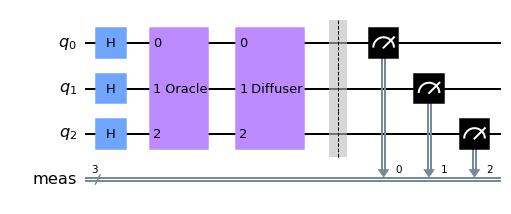

In [3]:
grover_circuit = QuantumCircuit(3)
oracle_circuit = QuantumCircuit(3)
oracle = oracle_circuit.to_gate()
oracle.name = " Oracle"
diffuser_circuit = QuantumCircuit(3)
diffuser = diffuser_circuit.to_gate()
diffuser.name = " Diffuser"

grover_circuit.h([0,1,2])
grover_circuit.append(oracle, [0,1,2])
grover_circuit.append(diffuser, [0,1,2])
grover_circuit.measure_all()

grover_circuit.draw()

## Diffuser
As the content of the diffuser gate does not depend on the solution(s) we are looking for, let us implement it first. The diffuser consists of the following steps:
<ol>
<li> 
  Apply H-gates to all qubits.
</li>
<li> 
  Apply X-gates to all qubits.
</li>
<li> 
  Apply multi-controlled Z-gate to all qubits.
</li>
<li> 
  Apply X-gates to all qubits.
</li>
<li> 
  Apply H-gates to all qubits.
</li>


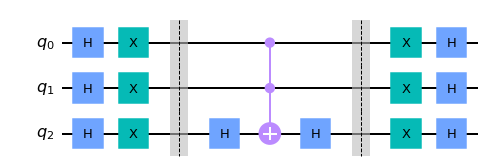

In [61]:
# From: https://qiskit.org/textbook/ch-algorithms/grover.html
n=3
qc = QuantumCircuit(n)
# Apply H-gates to all qubits
for qubit in range(n):
    qc.h(qubit)
# Apply X-gates to all qubits
for qubit in range(n):
    qc.x(qubit)
qc.barrier()
# Apply multi-controlled Z-gate to all qubits
qc.h(n-1)
qc.mct(list(range(n-1)), n-1)  # Using multi-controlled Toffoli-gate
qc.h(n-1)
qc.barrier()
# Apply X-gates to all qubits
for qubit in range(n):
    qc.x(qubit)
# Apply H-gates to all qubits
for qubit in range(n):
    qc.h(qubit)

qc.draw()

We want an universal implementation, so let's pack the diffuser into a function that takes the desired number of qubits n as an argument.

In [40]:
# From: https://qiskit.org/textbook/ch-algorithms/grover.html
def diffuser(n):
    qc = QuantumCircuit(n)
    # Apply H-gates to all qubits
    for qubit in range(n):
        qc.h(qubit)
    # Apply X-gates to all qubits
    for qubit in range(n):
        qc.x(qubit)
    # Apply multi-controlled Z-gate to all qubits
    qc.h(n-1)
    qc.mct(list(range(n-1)), n-1)  # Using multi-controlled Toffoli-gate
    qc.h(n-1)
    # Apply X-gates to all qubits
    for qubit in range(n):
        qc.x(qubit)
    # Apply H-gates to all qubits
    for qubit in range(n):
        qc.h(qubit)
    # Return the diffuser gate
    diffuser = qc.to_gate()
    diffuser.name = " W"
    return diffuser

## Single-Solution Oracle
There are 2 different types of oracle implementations for Grover search: Boolean and phase oracles. The Boolean approach is directly comparable to a classical search and requires one more "ancilliary" qubit to be used. We will use phase oracle implementation to save resources. From https://www.nature.com/articles/s41467-017-01904-7 we note that a single-solution oracle can be realized by the folloving steps:
<ol>
<li> 
  Apply X-gates to all qubits flagged as 0 in the solution.
</li>
<li> 
  Apply multi-controlled Z-gate to all qubits.
</li>
<li> 
  Apply X-gates to all qubits flagged as 0 in the solution.
</li>


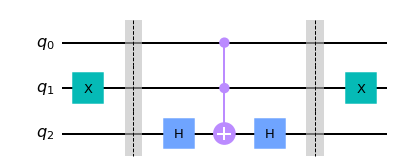

In [62]:
target = [1,0,1]
n=len(target)
qc = QuantumCircuit(n)
# Apply X-gates to all qubits flagged as 0
for qubit in range(n):
    if target[qubit] == 0:
        qc.x(qubit)
qc.barrier()
# Apply multi-controlled Z-gate to all qubits
qc.h(n-1)
qc.mct(list(range(n-1)), n-1)  # Using multi-controlled Toffoli-gate
qc.h(n-1)
qc.barrier()
# Apply X-gates to all qubits flagged as 0
for qubit in range(n):
    if target[qubit] == 0:
        qc.x(qubit)

qc.draw()

Again, we want this implementation to be usable for all single-state solutions. Let us make a function out of it.

In [56]:
def single_oracle(target):
    n=len(target)
    qc = QuantumCircuit(n)
    # Apply X-gates to all qubits flagged as 0
    for qubit in range(n):
        if target[qubit] == 0:
            qc.x(qubit)
    # Apply multi-controlled Z-gate
    qc.h(n-1)
    qc.mct(list(range(n-1)), n-1)  # Using multi-controlled Toffoli-gate
    qc.h(n-1)
    # Apply X-gates to all qubits flagged as 0
    for qubit in range(n):
        if target[qubit] == 0:
            qc.x(qubit)
    # Return the oracle gate
    single_oracle = qc.to_gate()
    single_oracle.name = " O"
    return single_oracle

## Putting It Together
We are now ready to plug in the diffuser and oracle to our Grover search circuit. An important note here is that qiskit has the order of the qubits flipped with respect to the publication https://www.nature.com/articles/s41467-017-01904-7, so we need to account for this in the code.

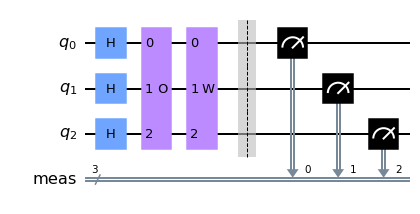

In [48]:
# Define target state
target = [1,0,1]
target.reverse()  # Important inclusion for our implementation.
n=len(target)
# Initialize the qubits
grover_circuit = QuantumCircuit(n)
grover_circuit.h([0,1,2])
# Plug in oracle
grover_circuit.append(single_oracle(target), [0,1,2])
# Plug in diffuser
grover_circuit.append(diffuser(n), [0,1,2])
# Measure the output
grover_circuit.measure_all()

grover_circuit.draw()

## Testing with Simulator

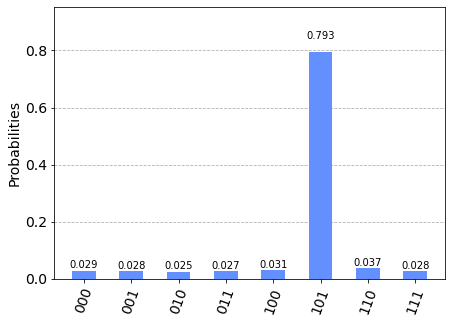

In [49]:
backend = Aer.get_backend('qasm_simulator')
results = execute(grover_circuit, backend=backend, shots=1024).result()
answer = results.get_counts()
plot_histogram(answer)

## Testing with Real Device

In [53]:
# Get the Least busy backend.
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("Least busy backend: ", backend)

Least busy backend:  ibmqx2


In [54]:
# Send the job to the least busy backend.
from qiskit.tools.monitor import job_monitor
job = execute(grover_circuit, backend=backend, shots=1024, optimization_level=3)
job_monitor(job, interval = 2)

Job Status: job has successfully run


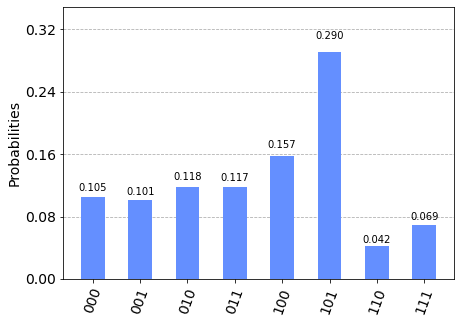

In [55]:
# Plot the results.
results = job.result()
answer = results.get_counts(grover_circuit)
plot_histogram(answer)

## Double-Solution Oracles
These are phase oracles according to https://www.nature.com/articles/s41467-017-01904-7 but flipped about the horizontal to account for reverse ordering of the qubits in qiskit.

In [8]:
# 000 & 001 Hardcoded
qc = QuantumCircuit(3)
qc.z(1)
qc.z(2)
qc.cz(1,2)

oracle_000_001 = qc.to_gate()
oracle_000_001.name = "$U_{000-001}$"

In [9]:
# 000 & 010 Hardcoded
qc = QuantumCircuit(3)
qc.z(0)
qc.z(2)
qc.cz(0,2)

oracle_000_010 = qc.to_gate()
oracle_000_010.name = "$U_{000-010}$"

In [10]:
# 000 & 011 Hardcoded
qc = QuantumCircuit(3)

qc.z(0)
qc.z(1)
qc.z(2)
qc.cz(1,2)
qc.cz(0,2)

oracle_000_011 = qc.to_gate()
oracle_000_011.name = "$U_{000-011}$"

In [11]:
# 000 & 100 Hardcoded
qc = QuantumCircuit(3)

qc.z(0)
qc.z(1)
qc.cz(0,1)

oracle_000_100 = qc.to_gate()
oracle_000_100.name = "$U_{000-100}$"

In [12]:
# 000 & 101 Hardcoded
qc = QuantumCircuit(3)

qc.z(0)
qc.z(1)
qc.z(2)
qc.cz(1,2)
qc.cz(0,1)

oracle_000_101 = qc.to_gate()
oracle_000_101.name = "$U_{000-101}$"

In [13]:
# 000 & 110 Hardcoded
qc = QuantumCircuit(3)

qc.z(0)
qc.z(1)
qc.z(2)
qc.cz(0,2)
qc.cz(0,1)

oracle_000_110 = qc.to_gate()
oracle_000_110.name = "$U_{000-110}$"

In [14]:
# 001 & 010 Hardcoded
qc = QuantumCircuit(3)

qc.z(0)
qc.z(1)
qc.cz(1,2)
qc.cz(0,2)

oracle_001_010 = qc.to_gate()
oracle_001_010.name = "$U_{001-010}$"

In [15]:
# 001 & 011 Hardcoded
qc = QuantumCircuit(3)

qc.z(0)
qc.cz(0,2)

oracle_001_011 = qc.to_gate()
oracle_001_011.name = "$U_{001-011}$"

In [16]:
# 001 & 100 Hardcoded
qc = QuantumCircuit(3)

qc.z(0)
qc.z(2)
qc.cz(1,2)
qc.cz(0,1)

oracle_001_100 = qc.to_gate()
oracle_001_100.name = "$U_{001-100}$"

In [17]:
# 001 & 101 Hardcoded
qc = QuantumCircuit(3)

qc.z(0)
qc.cz(0,1)

oracle_001_101 = qc.to_gate()
oracle_001_101.name = "$U_{001-101}$"

In [18]:
# 001 & 110 Hardcoded
qc = QuantumCircuit(3)

qc.z(0)
qc.cz(1,2)
qc.cz(0,2)
qc.cz(0,1)

oracle_001_110 = qc.to_gate()
oracle_001_110.name = "$U_{001-110}$"

In [19]:
# 001 & 111 Hardcoded
qc = QuantumCircuit(3)

qc.z(0)
qc.cz(0,2)
qc.cz(0,1)

oracle_001_111 = qc.to_gate()
oracle_001_111.name = "$U_{001-111}$"

In [20]:
# 010 & 011 Hardcoded
qc = QuantumCircuit(3)

qc.z(1)
qc.cz(1,2)

oracle_010_011 = qc.to_gate()
oracle_010_011.name = "$U_{010-011}$"

In [21]:
# 010 & 100 Hardcoded
qc = QuantumCircuit(3)

qc.z(1)
qc.z(2)
qc.cz(0,2)
qc.cz(0,1)

oracle_010_100 = qc.to_gate()
oracle_010_100.name = "$U_{010-100}$"

In [22]:
# 010 & 101 Hardcoded
qc = QuantumCircuit(3)

qc.z(1)
qc.cz(1,2)
qc.cz(0,2)
qc.cz(0,1)

oracle_010_101 = qc.to_gate()
oracle_010_101.name = "$U_{010-101}$"

In [23]:
# 010 & 110 Hardcoded
qc = QuantumCircuit(3)

qc.z(1)
qc.cz(0,1)

oracle_010_110 = qc.to_gate()
oracle_010_110.name = "$U_{010-110}$"

In [24]:
# 010 & 111 Hardcoded
qc = QuantumCircuit(3)

qc.z(1)
qc.cz(1,2)
qc.cz(0,1)

oracle_010_111 = qc.to_gate()
oracle_010_111.name = "$U_{010-111}$"

In [25]:
# 011 & 100 Hardcoded
qc = QuantumCircuit(3)

qc.z(2)
qc.cz(1,2)
qc.cz(0,2)
qc.cz(0,1)

oracle_011_100 = qc.to_gate()
oracle_011_100.name = "$U_{011-100}$"

In [26]:
# 011 & 101 Hardcoded
qc = QuantumCircuit(3)

qc.cz(0,2)
qc.cz(0,1)

oracle_011_101 = qc.to_gate()
oracle_011_101.name = "$U_{011-101}$"

In [27]:
# 011 & 110 Hardcoded
qc = QuantumCircuit(3)

qc.cz(1,2)
qc.cz(0,1)

oracle_011_110 = qc.to_gate()
oracle_011_110.name = "$U_{011-110}$"

In [28]:
# 011 & 111 Hardcoded
qc = QuantumCircuit(3)

qc.cz(0,1)

oracle_011_111 = qc.to_gate()
oracle_011_111.name = "$U_{011-111}$"

In [29]:
# 100 & 101 Hardcoded
qc = QuantumCircuit(3)

qc.z(2)
qc.cz(1,2)

oracle_100_101 = qc.to_gate()
oracle_100_101.name = "$U_{100-101}$"

In [30]:
# 100 & 110 Hardcoded
qc = QuantumCircuit(3)

qc.z(2)
qc.cz(0,2)

oracle_100_110 = qc.to_gate()
oracle_100_110.name = "$U_{100-110}$"

In [31]:
# 100 & 111 Hardcoded
qc = QuantumCircuit(3)

qc.z(2)
qc.cz(1,2)
qc.cz(0,2)

oracle_100_111 = qc.to_gate()
oracle_100_111.name = "$U_{100-111}$"

In [32]:
# 101 & 110 Hardcoded
qc = QuantumCircuit(3)

qc.cz(1,2)
qc.cz(0,2)

oracle_101_110 = qc.to_gate()
oracle_101_110.name = "$U_{101-110}$"

In [33]:
# 101 & 111 Hardcoded
qc = QuantumCircuit(3)

qc.cz(0,2)

oracle_101_111 = qc.to_gate()
oracle_101_111.name = "$U_{101-111}$"

In [34]:
# 110 & 111 Hardcoded
qc = QuantumCircuit(3)

qc.cz(1,2)

oracle_110_111 = qc.to_gate()
oracle_110_111.name = "$U_{110-111}$"

## Putting It Together
Now to substitute the double solution oracle into the Grover's search circuit.

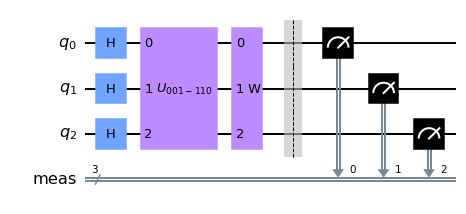

In [43]:
# Define target state
target = [1,0,1]
target.reverse()  # Important inclusion for our implementation.
n=len(target)
# Initialize the qubits
grover_circuit = QuantumCircuit(n)
grover_circuit.h([0,1,2])
# Plug in oracle
grover_circuit.append(oracle_001_110, [0,1,2])
# Plug in diffuser
grover_circuit.append(diffuser(n), [0,1,2])
# Measure the output
grover_circuit.measure_all()

grover_circuit.draw()

## Testing with Simulator

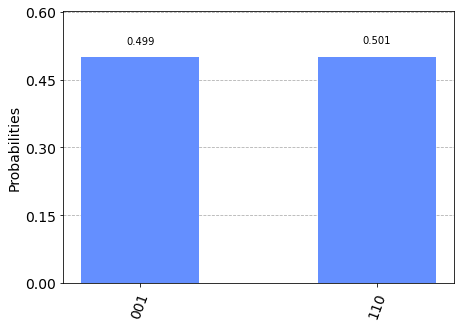

In [44]:
backend = Aer.get_backend('qasm_simulator')
results = execute(grover_circuit, backend=backend, shots=1024).result()
answer = results.get_counts()
plot_histogram(answer)

## Testing with Real Device

In [45]:
# Get the Least busy backend.
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("Least busy backend: ", backend)

Least busy backend:  ibmqx2


In [46]:
# Send the job to the least busy backend.
from qiskit.tools.monitor import job_monitor
job = execute(grover_circuit, backend=backend, shots=1024, optimization_level=3)
job_monitor(job, interval = 2)

Job Status: job has successfully run


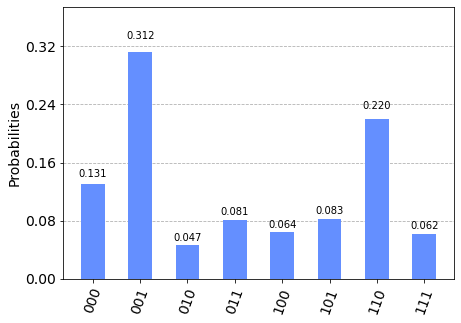

In [47]:
# Plot the results.
results = job.result()
answer = results.get_counts(grover_circuit)
plot_histogram(answer)

## References <a id='references'></a>
1. Qiskit Textbook https://qiskit.org/textbook/ch-algorithms/grover.html
2. C. Figgatt, D. Maslov, K. A. Landsman, N. M. Linke, S. Debnath & C. Monroe (2017), "Complete 3-Qubit Grover search on a programmable quantum computer", Nature Communications, Vol 8, Art 1918, [doi:10.1038/s41467-017-01904-7](https://doi.org/10.1038/s41467-017-01904-7), [arXiv:1703.10535 ](https://arxiv.org/abs/1703.10535)